In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import random
import math
import category_encoders as ce

## Loading data and basic analysis

In [ ]:
"""
# Reading the input data- Original dataset has 40,428,967 rows, which can be computationally expensive to load and process in its entirety. First randomly selecting a subset of 5,000,000 rows, it reduces the overall data size and allows for faster loading and initial exploration, subsequently , further restricting the sample to 100,000 rows allows for a smaller and more manageable dataset

num_records = 40428967
sample_size = 5000000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))      #line generates a list of row indices to be skipped when reading the dataset. It randomly selects (num_records - sample_size) row indices from the range of 1 to num_records, ensuring that the sample size is maintained.
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')                           # a custom date parsing function (parse_date) using lambda. It specifies the format of the 'hour' column in the dataset as '%y%m%d%H'

train = pd.read_csv("C:\\Users\\Rajesh Singh\\Downloads\\avazu-ctr-prediction\\train.gz", parse_dates=['hour'], date_parser=parse_date,\
                     skiprows=skip_values, nrows=100000)
train.head(2)
"""
#this would have loaded 100000 rows

In [79]:
num_records = 40428967
sample_size = 5000000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))      
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')                       

train = pd.read_csv("C:\\Users\\Rajesh Singh\\Downloads\\avazu-ctr-prediction\\train.gz", parse_dates=['hour'], date_parser=parse_date,\
                     skiprows=skip_values)
train.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10001868339616595934,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,17747,320,50,1974,2,39,100019,33
1,10003585669470236873,0,2014-10-21,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,1,0,17914,320,50,2043,2,39,-1,32


In [3]:
# Reading the test data.
test = pd.read_csv('C:\\Users\\Rajesh Singh\\Downloads\\avazu-ctr-prediction\\test.gz', parse_dates=['hour'], date_parser=parse_date)
test.head(2)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000017e+19,2014-10-31,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,100075,23
1,1.000018e+19,2014-10-31,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,22676,320,50,2616,0,35,100083,51


In [80]:
df_train = train.copy()

In [5]:
df_test = test.copy()

In [81]:
df_train.shape

(5000000, 24)

In [82]:
df_test.shape

(4577464, 23)

In [83]:
# Hour column contains event date with all the details, extracting the same to create different feature columns.

df_train['month'] = df_train['hour'].dt.month
df_train['dayofweek'] = df_train['hour'].dt.dayofweek
df_train['day'] = df_train['hour'].dt.day
df_train['hour_time'] = df_train['hour'].dt.hour
df_train.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
0,10001868339616595934,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,50,1974,2,39,100019,33,10,1,21,0
1,10003585669470236873,0,2014-10-21,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,50,2043,2,39,-1,32,10,1,21,0


In [84]:
# checking the sum of the null values across all cloumns and rows.

df_train['hour'].isnull().sum().sum()

0

In [85]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                uint64        
 1   click             int64         
 2   hour              datetime64[ns]
 3   C1                int64         
 4   banner_pos        int64         
 5   site_id           object        
 6   site_domain       object        
 7   site_category     object        
 8   app_id            object        
 9   app_domain        object        
 10  app_category      object        
 11  device_id         object        
 12  device_ip         object        
 13  device_model      object        
 14  device_type       int64         
 15  device_conn_type  int64         
 16  C14               int64         
 17  C15               int64         
 18  C16               int64         
 19  C17               int64         
 20  C18               int64         
 21  C19     

In [86]:
# looks like following columns have outliers  C15, C16, C19, C21. 

df_train.describe()

,id,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5000000.0,5.000000e+06,5.000000e+06,5.000000e+06
mean,9.228230e+18,1.698286e-01,1.004967e+03,2.880742e-01,1.014867e+00,3.316686e-01,1.884302e+04,3.188760e+02,6.006124e+01,2.112786e+03,1.432264e+00,2.270433e+02,5.324269e+04,8.337089e+01,10.0,2.601476e+00,2.547050e+01,1.127601e+01
std,5.324827e+18,3.754822e-01,1.093143e+00,5.060430e-01,5.262756e-01,8.554869e-01,4.959209e+03,2.113705e+01,4.717828e+01,6.093145e+02,1.326093e+00,3.508194e+02,4.995520e+04,7.028218e+01,0.0,1.727928e+00,2.963487e+00,5.954298e+00
min,6.622454e+12,0.000000e+00,1.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.750000e+02,1.200000e+02,2.000000e+01,1.120000e+02,0.000000e+00,3.300000e+01,-1.000000e+00,1.000000e+00,10.0,0.000000e+00,2.100000e+01,0.000000e+00
25%,4.616710e+18,0.000000e+00,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,1.692000e+04,3.200000e+02,5.000000e+01,1.863000e+03,0.000000e+00,3.500000e+01,-1.000000e+00,2.300000e+01,10.0,1.000000e+00,2.300000e+01,6.000000e+00
50%,9.230435e+18,0.000000e+00,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,2.034600e+04,3.200000e+02,5.000000e+01,2.323000e+03,2.000000e+00,3.900000e+01,1.000490e+05,6.100000e+01,10.0,2.000000e+00,2.600000e+01,1.100000e+01
75%,1.383913e+19,0.000000e+00,1.005000e+03,1.000000e+00,1.000000e+00,0.000000e+00,2.189400e+04,3.200000e+02,5.000000e+01,2.526000e+03,3.000000e+00,1.710000e+02,1.000940e+05,1.010000e+02,10.0,4.000000e+00,2.800000e+01,1.600000e+01
max,1.844674e+19,1.000000e+00,1.012000e+03,7.000000e+00,5.000000e+00,5.000000e+00,2.405200e+04,1.024000e+03,1.024000e+03,2.758000e+03,3.000000e+00,1.839000e+03,1.002480e+05,2.550000e+02,10.0,6.000000e+00,3.000000e+01,2.300000e+01


In [87]:
# Dealing with outliers by capping

col = ['C15', 'C16', 'C19', 'C21']
for col in col:
    percentiles = df_train[col].quantile(0.98)
    if df_train[col].quantile(0.98) < 0.5 * df_train[col].max():
        df_train[col][df_train[col] >= percentiles] = percentiles

### Types of Features

In [88]:
# define numerical and categorical featutres
numerical = [fea for fea in df_train.columns if df_train[fea].dtype !='O']
categorical = [fea for fea in df_train.columns if df_train[fea].dtype =='O']

# print
print(f'We have {len(numerical)} numerical features : {numerical}')
print(f'We have {len(categorical)} categorical features : {categorical}')

We have 19 numerical features : ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek', 'day', 'hour_time']
We have 9 categorical features : ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


In [89]:
df_train["click"].value_counts(normalize= True)

0    0.830171
1    0.169829
Name: click, dtype: float64

<AxesSubplot:xlabel='click', ylabel='count'>

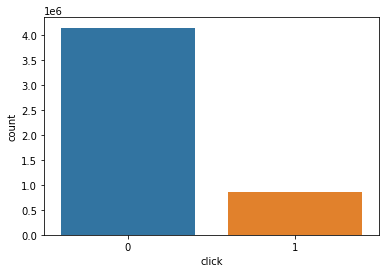

In [90]:
sns.countplot(x='click', data=df_train)

In [91]:
# y is the target variable, analysing the same.
# 83% values are 0 and 17% values are 1. data is highly imbalance. 

### Analyse the categorical columns

In [92]:
categorical

['site_id',
 'site_domain',
 'site_category',
 'app_id',
 'app_domain',
 'app_category',
 'device_id',
 'device_ip',
 'device_model']

In [93]:
print("unique counts of site_id", len(df_train['site_id'].unique()))
print("----------------------")
print(df_train['site_id'].value_counts(normalize = True))

unique counts of site_id 3576
----------------------
85f751fd    3.608788e-01
1fbe01fe    1.599852e-01
e151e245    6.532720e-02
d9750ee7    2.394420e-02
5b08c53b    2.251860e-02
                ...     
38df0c75    2.000000e-07
34f59754    2.000000e-07
0afe1d37    2.000000e-07
7088eee7    2.000000e-07
945cd90c    2.000000e-07
Name: site_id, Length: 3576, dtype: float64


In [94]:
print("unique counts of site_domain", len(df_train['site_domain'].unique()))
print("----------------------")
print(df_train['site_domain'].value_counts(normalize = True))

unique counts of site_domain 4488
----------------------
c4e18dd6    3.742402e-01
f3845767    1.599852e-01
7e091613    8.233640e-02
7687a86e    3.179200e-02
98572c79    2.476480e-02
                ...     
c754cdec    2.000000e-07
5c9c3980    2.000000e-07
a90a5216    2.000000e-07
114d3cd8    2.000000e-07
6e5c932a    2.000000e-07
Name: site_domain, Length: 4488, dtype: float64


In [95]:
print("unique counts of site_category", len(df_train['site_category'].unique()))
print("----------------------")
print(df_train['site_category'].value_counts(normalize = True))

unique counts of site_category 24
----------------------
50e219e0    4.089234e-01
f028772b    3.136614e-01
28905ebd    1.820816e-01
3e814130    7.541880e-02
f66779e6    6.215400e-03
75fa27f6    3.926000e-03
335d28a8    3.387600e-03
76b2941d    2.605000e-03
c0dd3be3    1.036000e-03
72722551    6.940000e-04
dedf689d    6.146000e-04
70fb0e29    5.992000e-04
0569f928    4.322000e-04
8fd0aea4    1.846000e-04
a818d37a    7.800000e-05
42a36e14    6.420000e-05
e787de0e    3.020000e-05
bcf865d9    2.680000e-05
5378d028    1.080000e-05
9ccfa2ea    8.800000e-06
74073276    6.000000e-07
da34532e    4.000000e-07
6432c423    2.000000e-07
c706e647    2.000000e-07
Name: site_category, dtype: float64


In [96]:
print("unique counts of app_id", len(df_train['app_id'].unique()))
print("----------------------")
print(df_train['app_id'].value_counts(normalize = True))

unique counts of app_id 5178
----------------------
ecad2386    6.391212e-01
92f5800b    3.868060e-02
e2fcccd2    2.788220e-02
9c13b419    1.879460e-02
febd1138    1.872920e-02
                ...     
20c50d7a    2.000000e-07
e0736a58    2.000000e-07
e72e31f1    2.000000e-07
72785dd5    2.000000e-07
15245f4e    2.000000e-07
Name: app_id, Length: 5178, dtype: float64


In [97]:
print("unique counts of app_domain", len(df_train['app_domain'].unique()))
print("----------------------")
print(df_train['app_domain'].value_counts(normalize = True))

unique counts of app_domain 321
----------------------
7801e8d9    6.737280e-01
2347f47a    1.296276e-01
ae637522    4.682400e-02
5c5a694b    2.788840e-02
82e27996    1.873040e-02
                ...     
d89240fd    2.000000e-07
a7accd5b    2.000000e-07
25628028    2.000000e-07
971c3ba7    2.000000e-07
a5ab1a9f    2.000000e-07
Name: app_domain, Length: 321, dtype: float64


In [98]:
print("unique counts of app_category", len(df_train['app_category'].unique()))
print("----------------------")
print(df_train['app_category'].value_counts(normalize = True))

unique counts of app_category 30
----------------------
07d7df22    6.473602e-01
0f2161f8    2.360740e-01
cef3e649    4.294460e-02
8ded1f7a    3.633320e-02
f95efa07    2.831380e-02
d1327cf5    3.066000e-03
dc97ec06    1.393800e-03
09481d60    1.339800e-03
75d80bbe    9.856000e-04
fc6fa53d    5.864000e-04
4ce2e9fc    5.174000e-04
879c24eb    3.130000e-04
a3c42688    2.750000e-04
4681bb9d    1.528000e-04
0f9a328c    1.350000e-04
a86a3e89    6.260000e-05
2281a340    4.740000e-05
8df2e842    3.680000e-05
79f0b860    1.740000e-05
0bfbc358    1.140000e-05
7113d72a    9.000000e-06
a7fd01ec    9.000000e-06
2fc4f2aa    5.600000e-06
18b1e0be    5.400000e-06
5326cf99    3.200000e-06
4b7ade46    4.000000e-07
6fea3693    4.000000e-07
0d82db25    4.000000e-07
bd41f328    2.000000e-07
bf8ac856    2.000000e-07
Name: app_category, dtype: float64


In [99]:
print("unique counts of device_id", len(df_train['device_id'].unique()))
print("----------------------")
print(df_train['device_id'].value_counts(normalize = True))

unique counts of device_id 599409
----------------------
a99f214a    8.252596e-01
0f7c61dc    5.254000e-04
c357dbff    4.822000e-04
936e92fb    3.348000e-04
afeffc18    2.444000e-04
                ...     
4204d887    2.000000e-07
036445b0    2.000000e-07
a32224eb    2.000000e-07
426b26dc    2.000000e-07
454877d9    2.000000e-07
Name: device_id, Length: 599409, dtype: float64


In [100]:
print("unique counts of device_ip", len(df_train['device_ip'].unique()))
print("----------------------")
print(df_train['device_ip'].value_counts(normalize = True))

unique counts of device_ip 1906732
----------------------
6b9769f2    5.156800e-03
431b3174    3.343600e-03
2f323f36    2.203800e-03
af9205f9    2.166800e-03
930ec31d    2.158200e-03
                ...     
da65d6a3    2.000000e-07
4992924d    2.000000e-07
594b6bc4    2.000000e-07
bda11479    2.000000e-07
2dfaa2fb    2.000000e-07
Name: device_ip, Length: 1906732, dtype: float64


In [101]:
print("unique counts of device_model", len(df_train['device_model'].unique()))
print("----------------------")
print(df_train['device_model'].value_counts(normalize = True))

unique counts of device_model 6556
----------------------
8a4875bd    6.074520e-02
1f0bc64f    3.522780e-02
d787e91b    3.467900e-02
76dc4769    1.899740e-02
be6db1d7    1.839600e-02
                ...     
5965abc0    2.000000e-07
4983d9f4    2.000000e-07
2fbdbfc0    2.000000e-07
7762b516    2.000000e-07
a27913e8    2.000000e-07
Name: device_model, Length: 6556, dtype: float64


observations :
* All categorical variables have lot of unique values in it, one hot encoding is not a scalable approach.
* we will go with label encoding and scaling approach is a better idea for this.

In [ ]:
# The code below will plot histograms for all numerical columns 

n=2
plt.figure(figsize=[15,3*math.ceil(len(numerical)/n)])

for i in range(len(numerical)):
    plt.subplot(math.ceil(len(numerical)/n),n,i+1)
    sns.distplot(df_train[numerical[i]])

plt.tight_layout()
plt.show()

Text(0.5, 1.05, 'Pearson correlation of Features')

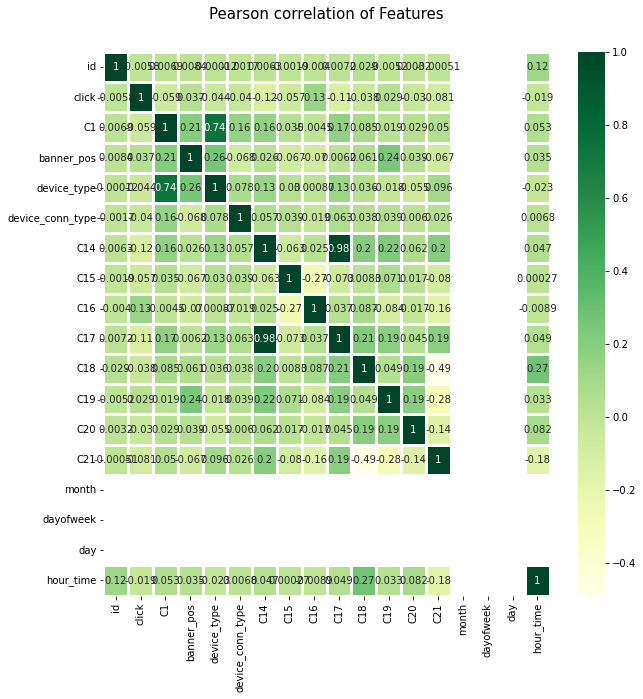

In [28]:
# Pearson correlation table to find the relationship with output with all input features. 

corr = df_train.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax, annot=True,linewidths=3,cmap='YlGn')
plt.title("Pearson correlation of Features", y=1.05, size=15)

observation
* month has got no significance, better to drop it
* C14 and C17 are highly co-related, later will remove one of them after the base model.
* device type with C1 are highly co-related, later will remove one of them after the base model.
* Removing C20 anomalised column, since it have got nearly 47% of values with -1. As a categorical variable it's not expected to have values as -1.

In [103]:
# as said above dropping columns. 

df_train.drop(['month', 'C20'], axis=1, inplace=True)
df_train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day',
       'hour_time'],
      dtype='object')

### Data preperation


In [104]:
# id column have a unique columns so, keeping that don't proive any significance,hence dropping.
# hour column have been derived into different columns, hence dropping. 
# rename click to y (output)
# after dropping hour column, hour_time can be made as hour

df_train.drop(['id', 'hour'], axis = 1, inplace = True) 
df_train.rename(columns={'click': 'y',
                   'hour_time': 'hour'},
          inplace=True, errors='raise')

df_train.columns

Index(['y', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day', 'hour'],
      dtype='object')

In [105]:
# dataset is huge and running multiple algo will take time and resources might exhaust, 
# hence taking only 10% of the data for analysis.

sampled_data = df_train.sample(frac=0.1, random_state=42)

#### defining functions for later use.

In [106]:
# this function helps in evaluation the given model and provide accuracy and confusion matrix. 

def model_eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    #print(accuracy)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    #print(cnf_matrix)
    #metrics.plot_confusion_matrix(model, X_test, y_test)
    #plt.show()
    return accuracy, cnf_matrix

In [107]:
# Plots the ROC curve and returns false positive rate, true positive rate, and thresholds. 

def draw_roc(model, Xtest, actual):
    probs = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [108]:
# Returns the ctossvalidation score for given number of n folds. 

def cross_val (model, x, y, folds):
    crossvalidation = cross_val_score(model, x, y, cv= folds, n_jobs=-1)
    return crossvalidation

In [109]:
# this stores the results in dataframe for evaluating the final result. 

def store_results(name, ytrain, xtrain, ytest, xtest, model, folds):
    
    crossvalidation = cross_val(model, xtrain, ytrain, folds)
    
    accuracy_test, cm1 =  model_eval(model, xtrain, ytrain)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_test = TP / (TP+FP)
    precision_test = TP / (TP+FN)
    
    accuracy_train, cm1 =  model_eval(model, xtest, ytest)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_train = TP / (TP+FP)
    precision_train = TP / (TP+FN)

    entry = {'Model': [name],
          'Accuracy_train': [accuracy_train],
          'recall_train': [recall_train],
          'precision_train': [precision_train],
          'Accuracy_test': [accuracy_train],
          'recall_test': [recall_train],
          'precision_test': [precision_train],
          'CrossVal_Mean': [crossvalidation.mean()],           
          'CrossVal1': [crossvalidation[0]],
          'CrossVal2': [crossvalidation[1]],
          'CrossVal3': [crossvalidation[2]],
          'CrossVal4': [crossvalidation[3]],
          'CrossVal5': [crossvalidation[4]],
          }
    result = pd.DataFrame(entry)
    return result

In [134]:
# Dummy classifier helps in baseling the model performace w.r.t dominanat class.
outcome = pd.DataFrame()
dummy_clf = DummyClassifier(strategy= "most_frequent")
dummy_clf.fit(X_train, y_train)
accuracy, cnf_matrix  = model_eval(dummy_clf, X_train, y_train)
print(accuracy)
print(cnf_matrix)
temp = store_results("Dummy classifier", y_train, X_train, y_test, X_test, dummy_clf, 5)
outcome = outcome.append(temp)
outcome

0.500000859728429
[[     0 290789]
 [     0 290790]]


,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.499998,0.499998,1.0,0.499998,0.499998,1.0,0.499999,0.5,0.5,0.5,0.5,0.499996


### Building basic models

In [110]:
data_feature = sampled_data.copy()

Text(0.5, 1.05, 'Pearson correlation of Features')

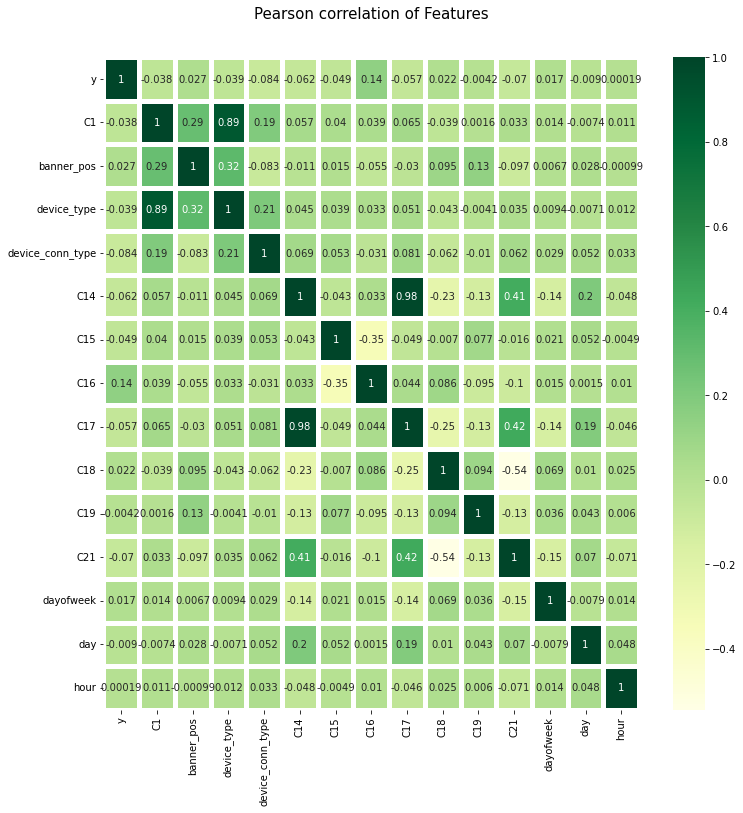

In [111]:
corr = data_feature.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr, ax=ax, annot=True, linewidths=5,cmap='YlGn')
plt.title("Pearson correlation of Features", y=1.05, size=15)

In [112]:
# C1 and device_type are highly corelated, since C1 is anomalised column we can drop it.
# C14 and C17 are highly co-related, dropping either is a good idea.

data_feature.drop(['C14', 'C1'], axis=1, inplace= True)

In [113]:
X = data_feature.drop(['y'], axis=1)
y = data_feature['y']

In [59]:
##use of target encoding is to transform categorical variables into numerical representations based on the relationship with the target variable. It can be particularly helpful in machine learning tasks where the categorical variables may contain valuable information related to the target variable. For example, in teh below dataframe, each value of the "site_id" column will change to a mean of "y" value for that particular vale.
##use this when :
# categorical features has large number of categories, 
# if there is strong relation or correlation between a categorical variable and the target variable, 
# it can effectively capture non-linear relationships between categorical variable and teh target variable, by using statistical measures such as means or medians, target encoding can reveal complex patterns that me not be evident with simpe lable encoding or one hot encoding
# Limited Sample Size: In situations where the sample size is limited, target encoding can provide more stable estimates compared to other encoding techniques,
# Predictive Modeling Tasks: Target encoding is commonly used in tasks where the prediction of a target variable is the objective, such as regression or classification problems. By encoding categorical variables based on their relationship with the target, the model can benefit from the additional information and potentially improve its predictive performance.

In [114]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,...,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
3577888,1,0.118014,0.121838,0.127741,0.094096,0.137545,0.107502,0.147161,0.143041,0.149660,...,0,300,50,1863,3,39,23,1,28,10
4993932,0,0.118014,0.121838,0.127741,0.194544,0.194503,0.107502,0.147161,0.147161,0.169503,...,0,320,50,2526,0,167,221,3,30,23


Original dataset shape  Counter({0: 415414, 1: 84586})
Resampled dataset shape Counter({0: 415414, 1: 415414})


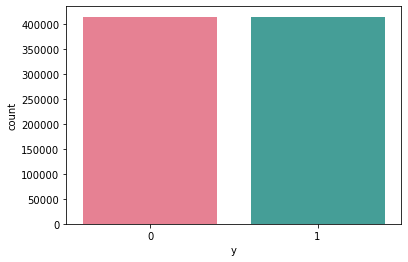

In [115]:
# we will balance the data ,as it is unbalanced
from imblearn.over_sampling import RandomOverSampler
randomsample=  RandomOverSampler()
x_new, y_new = randomsample.fit_resample(X, y)

from collections import Counter
print('Original dataset shape  {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))
sns.countplot(y_new, palette='husl')
plt.show()

In [116]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

### Logistic regression model with feature engineering and balance precidtor

In [117]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,...,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
374714,0.000000,0.107308,0.153330,0.268204,0.198383,0.276760,0.603883,0.341666,0.254124,0.251267,...,0.0,1.00,0.130435,0.896030,1.000000,0.074197,0.086614,0.666667,0.333333,0.347826
517255,0.571429,0.270484,0.299421,0.376139,0.198383,0.276760,0.603883,0.210102,0.399493,0.355778,...,0.0,1.00,0.130435,0.799622,0.000000,0.499446,0.185039,0.000000,0.666667,0.652174
375622,0.000000,0.265896,0.314907,0.433129,0.198383,0.276760,0.603883,0.210102,0.204511,0.365399,...,0.0,1.00,0.130435,0.608696,0.000000,0.001107,0.307087,0.833333,0.444444,0.391304
583724,0.000000,0.153533,0.187725,0.268204,0.065554,0.093723,0.239641,0.210102,0.385892,0.107887,...,0.0,1.00,0.130435,0.998866,0.000000,0.001107,0.964567,0.500000,1.000000,0.565217
331488,0.142857,0.391286,0.402077,0.376139,0.198383,0.276760,0.603883,0.210102,0.204511,0.448056,...,0.0,0.48,0.069565,0.534594,0.666667,0.075305,0.133858,0.500000,0.222222,0.086957


In [118]:
X_train_sm = sm.add_constant(X_train)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               581579
Model:                            GLM   Df Residuals:                   581557
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5710e+05
Date:                Mon, 05 Jun 2023   Deviance:                   3.1420e+05
Time:                        15:48:11   Pearson chi2:                 8.64e+13
No. Iterations:                    10   Pseudo R-squ. (CS):             0.5709
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -21.8432      0.170   -128.557      0.000     -22.176     -21.510
banner_pos           1.2486      0.080     15.573      0.000       1.091       1.406
site_id             -9.5531      0.112    -85.414      0.000      -9.772      -9.334
site_domain         12.1026      0.104    116.897      0.000      11.900      12.306
site_category        1.3618      0.069     19.869      0.000       1.227       1.496
app_id               7.2269      0.154     46.949      0.000       6.925       7.529
app_domain          -4.2112      0.138    -30.614      0.000      -4.481      -3.942
app_category        -1.0529      0.049    -21.453      0.000      -1.149      -0.957
device_id           48.4339      0.532     91.110      0.000      47.392      49.476
device_ip           30.4362      0.082    370.402      0.000      30.275      30.597
device_model         0.7088      0.056     12.700      0.000       0.599       0.818
device_type          0.2772      0.101      2.736      0.006       0.079       0.476
device_conn_type     0.0957      0.040      2.404      0.016       0.018       0.174
C15                  1.8706      0.114     16.455      0.000       1.648       2.093
C16                 -0.6762      0.033    -20.319      0.000      -0.741      -0.611
C17                  0.0827      0.026      3.225      0.001       0.032       0.133
C18                 -0.1282      0.014     -9.325      0.000      -0.155      -0.101
C19                  0.3684      0.025     15.035      0.000       0.320       0.416
C21                 -0.2240      0.022    -10.029      0.000      -0.268      -0.180
dayofweek            0.0474      0.016      2.937      0.003       0.016       0.079
day                 -0.0684      0.015     -4.670      0.000      -0.097      -0.040
hour                -0.2296      0.018    -12.739      0.000      -0.265      -0.194
====================================================================================
"""

In [119]:
y_train_pred = res.predict(X_train_sm)
y_train_pred_final = pd.DataFrame({'y':y_train, 'y_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
print(confusion)
print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))

[[262347  28442]
 [ 33399 257391]]
0.8936670684464192


In [120]:
def sm_model_evaluation (model, x_test, y_test):
    '''
    model = sm model
    y_test = series of labels 
    columns = list of columns in features
    x_test = test dataframe 
    '''
    X_sm = sm.add_constant(x_test)
    y_pred = res.predict(X_sm)
    y_train_pred_final = pd.DataFrame({'y':y_test, 'y_Prob':y_pred})
    y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
    # Let's check the overall accuracy.
    print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))
    confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
    print(confusion)

In [121]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
sm_model_evaluation(res, X_test, y_test) 

0.8941139182103037
[[112395  12230]
 [ 14162 110462]]


In [122]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,624.08
2,site_id,8.96
3,site_domain,8.95
7,app_category,2.34
6,app_domain,2.23
14,C16,2.17
5,app_id,2.14
4,site_category,2.08
18,C21,1.77
16,C18,1.63


In [123]:
# VIF looks good, w.r.t P values hour and dayofweek have got highest, will remove and build the model.

X_train_sm.drop(['hour','day'], axis=1, inplace= True)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               581579
Model:                            GLM   Df Residuals:                   581559
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5720e+05
Date:                Mon, 05 Jun 2023   Deviance:                   3.1439e+05
Time:                        15:51:32   Pearson chi2:                 9.08e+13
No. Iterations:                    10   Pseudo R-squ. (CS):             0.5707
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -21.9661      0.169   -129.602      0.000     -22.298     -21.634
banner_pos           1.2530      0.080     15.629      0.000       1.096       1.410
site_id             -9.5874      0.112    -85.886      0.000      -9.806      -9.369
site_domain         12.1056      0.103    117.109      0.000      11.903      12.308
site_category        1.3749      0.069     20.061      0.000       1.241       1.509
app_id               7.1795      0.154     46.644      0.000       6.878       7.481
app_domain          -4.1149      0.137    -29.961      0.000      -4.384      -3.846
app_category        -1.0743      0.049    -21.896      0.000      -1.170      -0.978
device_id           48.5105      0.532     91.108      0.000      47.467      49.554
device_ip           30.4170      0.082    370.495      0.000      30.256      30.578
device_model         0.7213      0.056     12.930      0.000       0.612       0.831
device_type          0.2474      0.101      2.442      0.015       0.049       0.446
device_conn_type     0.0862      0.040      2.167      0.030       0.008       0.164
C15                  1.8470      0.113     16.322      0.000       1.625       2.069
C16                 -0.6713      0.033    -20.191      0.000      -0.736      -0.606
C17                  0.0657      0.025      2.611      0.009       0.016       0.115
C18                 -0.1326      0.014     -9.651      0.000      -0.160      -0.106
C19                  0.3627      0.024     14.829      0.000       0.315       0.411
C21                 -0.2073      0.022     -9.301      0.000      -0.251      -0.164
dayofweek            0.0477      0.016      2.959      0.003       0.016       0.079
====================================================================================
"""

In [124]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,618.39
2,site_id,8.95
3,site_domain,8.95
7,app_category,2.33
6,app_domain,2.23
14,C16,2.17
5,app_id,2.14
4,site_category,2.08
18,C21,1.76
16,C18,1.62


In [125]:
X_train_sm.drop(['dayofweek','device_ip', 'C15'], axis=1, inplace= True)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               581579
Model:                            GLM   Df Residuals:                   581562
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.0192e+05
Date:                Mon, 05 Jun 2023   Deviance:                   6.0385e+05
Time:                        15:53:26   Pearson chi2:                 5.13e+17
No. Iterations:                    10   Pseudo R-squ. (CS):             0.2939
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -17.4795      0.119   -147.191      0.000     -17.712     -17.247
banner_pos          -0.0161      0.054     -0.300      0.764      -0.122       0.089
site_id              2.5111      0.081     31.049      0.000       2.353       2.670
site_domain          2.7242      0.075     36.341      0.000       2.577       2.871
site_category        0.3688      0.046      7.968      0.000       0.278       0.460
app_id              11.4141      0.106    107.739      0.000      11.206      11.622
app_domain          -3.0879      0.091    -34.091      0.000      -3.265      -2.910
app_category        -1.5374      0.032    -47.737      0.000      -1.600      -1.474
device_id           69.8064      0.558    125.111      0.000      68.713      70.900
device_model         2.6984      0.037     72.700      0.000       2.626       2.771
device_type          1.3223      0.079     16.793      0.000       1.168       1.477
device_conn_type     0.0661      0.027      2.472      0.013       0.014       0.119
C16                 -0.8020      0.022    -36.123      0.000      -0.845      -0.758
C17                 -0.0772      0.016     -4.850      0.000      -0.108      -0.046
C18                 -0.1799      0.009    -19.705      0.000      -0.198      -0.162
C19                  0.0539      0.016      3.276      0.001       0.022       0.086
C21                 -0.2568      0.015    -17.268      0.000      -0.286      -0.228
====================================================================================
"""

In [126]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,90.89
3,site_domain,8.94
2,site_id,8.91
7,app_category,2.32
6,app_domain,2.21
4,site_category,2.08
5,app_id,2.07
12,C16,1.93
16,C21,1.75
14,C18,1.62


Model P values and VIF looks good, will find the best threshold for classification.

In [127]:
y_train_pred = res.predict(X_train_sm)
y_train_pred_final = pd.DataFrame({'y':y_train, 'y_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
print(confusion)
print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))

[[198010  92779]
 [ 64729 226061]]
0.7291717892152227


In [128]:
col = list(X_train_sm.columns)
col.remove('const')
sm_model_evaluation(res, X_test[col], y_test)  

0.7293268980015968
[[85141 39484]
 [27981 96643]]


In [129]:
numbers = [float(x)/20 for x in range(20)]
print(numbers)
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.y_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


,y,y_Prob,predicted,0.0,0.05,0.1,0.15,0.2,0.25,0.3,...,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
374714,1,0.999645,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
517255,1,0.581820,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0
375622,0,0.592343,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0
583724,1,0.167897,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
331488,0,0.751901,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0


In [130]:
cutoff_df = pd.DataFrame( columns = ['Thresold_prob','accuracy','recall','precision'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    accuracy = (TP + TN)/total1
    
    recall = TP / (TP+FP)
    precision = TP / (TP+FN)
    cutoff_df.loc[i] =[ i ,accuracy,recall,precision]
cutoff_df

,Thresold_prob,accuracy,recall,precision
0.00,0.00,0.500001,0.500001,1.000000
0.05,0.05,0.544179,0.523115,0.999825
0.10,0.10,0.580367,0.543741,0.999047
0.15,0.15,0.625550,0.572635,0.989814
0.20,0.20,0.655065,0.594549,0.975092
0.25,0.25,0.683463,0.618343,0.958602
0.30,0.30,0.701776,0.637085,0.937732
0.35,0.35,0.716912,0.657364,0.906118
0.40,0.40,0.727024,0.676423,0.870436
0.45,0.45,0.728439,0.686657,0.840362


In [131]:
y_train_pred_final['final_predicted'] = y_train_pred_final.y_Prob.map( lambda x: 1 if x > 0.50 else 0)
y_train_pred_final.head()

,y,y_Prob,predicted,0.0,0.05,0.1,0.15,0.2,0.25,0.3,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,final_predicted
374714,1,0.999645,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
517255,1,0.581820,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,1
375622,0,0.592343,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,1
583724,1,0.167897,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
331488,0,0.751901,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,1


In [132]:
X_train_sm.drop('const', axis= 1, inplace= True)
X_test = X_test[X_train_sm.columns]
print(X_train_sm.shape)
print(X_test.shape)

(581579, 16)
(249249, 16)


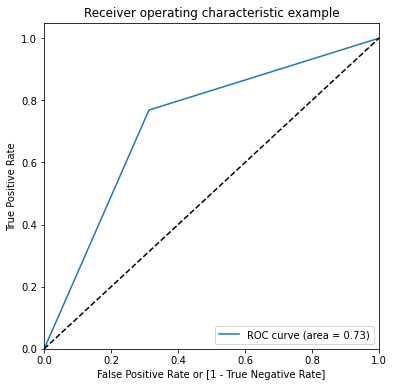

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.499998,0.499998,1.000000,0.499998,0.499998,1.000000,0.499999,0.500000,0.500000,0.500000,0.500000,0.499996
0,logistic reg with feature engine,0.727854,0.710681,0.768608,0.727854,0.710681,0.768608,0.727621,0.725601,0.728223,0.729943,0.726005,0.728333


In [135]:
model = LogisticRegression()
model.fit(X_train_sm, y_train)
accuracy, cnf_matrix = model_eval(model, X_test[X_train_sm.columns], y_test)
temp = store_results("logistic reg with feature engine", y_train, X_train_sm, y_test, X_test[X_train_sm.columns], \
                     model, 5)
draw_roc(model, X_test[X_train_sm.columns], y_test)
outcome = outcome.append(temp)
outcome

#### Random forest model with feature engineering and balance precidtor

In [142]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,...,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
374714,0,0.082483,0.099515,0.127741,0.198015,0.194176,0.198522,0.277270,0.182750,0.157068,...,0,320,50,2482,3,167,23,4,24,8
517255,4,0.207909,0.194332,0.179135,0.198015,0.194176,0.198522,0.173311,0.287026,0.220336,...,0,320,50,2227,0,935,48,0,27,15


In [143]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
feature_importances = model_rf.feature_importances_
features = X_train.columns
df = pd.DataFrame({'features': features, 'importance': feature_importances})
df.sort_values(by='importance', ascending = False)

,features,importance
8,device_ip,0.641449
7,device_id,0.075989
9,device_model,0.066952
20,hour,0.050778
2,site_domain,0.031963
1,site_id,0.030982
4,app_id,0.021139
19,day,0.013114
18,dayofweek,0.011606
14,C17,0.011181


using random forest feature importance metric to decide on best features and building the model

['site_id', 'site_domain', 'app_id', 'device_id', 'device_ip', 'device_model', 'hour']
7
Train results
accuracy 0.9874152952565344
cnf_matrix 
 [[284882   5907]
 [  1412 289378]]
Test results
accuracy 0.9576728492391143
cnf_matrix 
 [[115684   8941]
 [  1609 123015]]


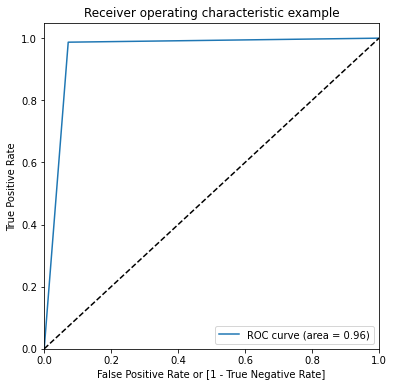

(array([0.        , 0.07174323, 1.        ]),
 array([0.        , 0.98708916, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [144]:
df = df[df.importance > 0.02]
rf_cols = []
for col in list(X_train.columns):
    if col in list(df.features):
        rf_cols.append(col)
        
X_train = X_train[rf_cols]
X_test = X_test[rf_cols]

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
print(rf_cols)

print(len(rf_cols))
predict_rf = model_rf.predict(X_train)
predict_rf_test = model_rf.predict(X_test)

accuracy, cnf_matrix = model_eval(model_rf, X_train, y_train)
print("Train results")
print("accuracy",accuracy)
print("cnf_matrix \n", cnf_matrix)

accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print("Test results")
print("accuracy",accuracy)
print("cnf_matrix \n", cnf_matrix)

draw_roc(model_rf, X_test, y_test)

In [145]:
temp = store_results("Random Forest with feature engine", y_train, X_train, y_test, X_test, \
                     model_rf, 5)
outcome = outcome.append(temp)

In [146]:
outcome.reset_index(drop=True, inplace=True)
outcome

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.499998,0.499998,1.000000,0.499998,0.499998,1.000000,0.499999,0.500000,0.500000,0.500000,0.500000,0.499996
1,logistic reg with feature engine,0.727854,0.710681,0.768608,0.727854,0.710681,0.768608,0.727621,0.725601,0.728223,0.729943,0.726005,0.728333
2,Random Forest with feature engine,0.957673,0.932243,0.987089,0.957673,0.932243,0.987089,0.951154,0.951159,0.951348,0.951314,0.951159,0.950789
